In [2]:
import functools

import tqdm
import equinox as eqx
import jax

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import optax
from jaxtyping import Array, PyTree, Float, Complex, PRNGKeyArray

import netket as nk
from netket.operator import FermionOperator2ndJax
from netket.operator.fermion import destroy as c
from netket.operator.fermion import create as cdag
from netket.operator.fermion import number as nc

import matplotlib.pyplot as plt

from models.nnwfn import AWFN

key = jax.random.key(42)

## Construct Hilbert spaces and Hamiltonian operator
- Hilbertspace
\begin{equation}
    \mathcal H = \operatorname{span}\{\ket{n}:n \in \mathcal L(L_x, L_y, ...)\},\quad F_{-} (\mathcal H) = \bigoplus_{n=0}^\infty S_{-}\mathcal H^{\otimes n}
\end{equation}
Where $\mathcal L(L_x, L_y, ...)$ is square lattice with lengths $L_x, L_y, ...$.


- Hamiltonian operator
\begin{equation}
    H=-t\sum_{\braket{\mathbf r, \mathbf r'}, \sigma} [c_{\sigma}^\dagger(\mathbf r')c_{\sigma}(\mathbf r) + c_{\sigma}^\dagger(\mathbf r)c_{\sigma}(\mathbf r')] + U\sum_{\mathbf r} n_\uparrow (\mathbf r) n_\downarrow (\mathbf r)
\end{equation}


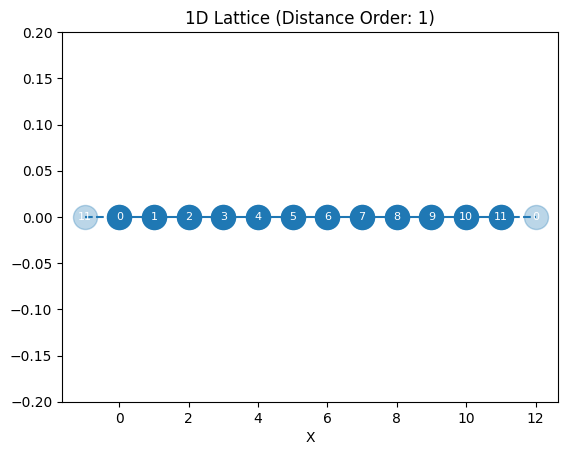

<Axes: title={'center': '1D Lattice (Distance Order: 1)'}, xlabel='X'>

In [6]:
def construct_system(t: float, U: float, N: int, L: list[int], pbc=True) -> tuple[nk.hilbert.SpinOrbitalFermions, FermionOperator2ndJax]:
    hi = nk.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions=N)
    H = FermionOperator2ndJax(hi)
    
    graph = nk.graph.Grid(L, pbc=pbc)
    for (r1, r2) in graph.edges():
        for s in [-1, 1]:
            H += -t * (cdag(hi, r1, s) * c(hi, r2, s) + cdag(hi, r2, s) * c(hi, r1, s))
    
    for r in graph.nodes():
        H += U * nc(hi, r, -1) * nc(hi, r, 1)
    
    return hi, H

t = 1.0
U = 4.0
N = 6
L = [12,]
PBC = True

graph = nk.graph.Grid(L, pbc=PBC)
graph_extended = nk.graph.disjoint_union(graph, graph)

graph.draw()

In [7]:
hi = nk.hilbert.SpinOrbitalFermions(graph_extended.n_nodes, s=1/2, n_fermions=N)

H = FermionOperator2ndJax(hi)
for (r1, r2) in graph.edges():
    for s in [-1, 1]:
        H += -t * (cdag(hi, r1, s) * c(hi, r2, s) + cdag(hi, r2, s) * c(hi, r1, s))

for r in graph.nodes():
    H += U * nc(hi, r, -1) * nc(hi, r, 1)